# <center>**Detect Lung Cancer using patient diagnosis data.**</center>
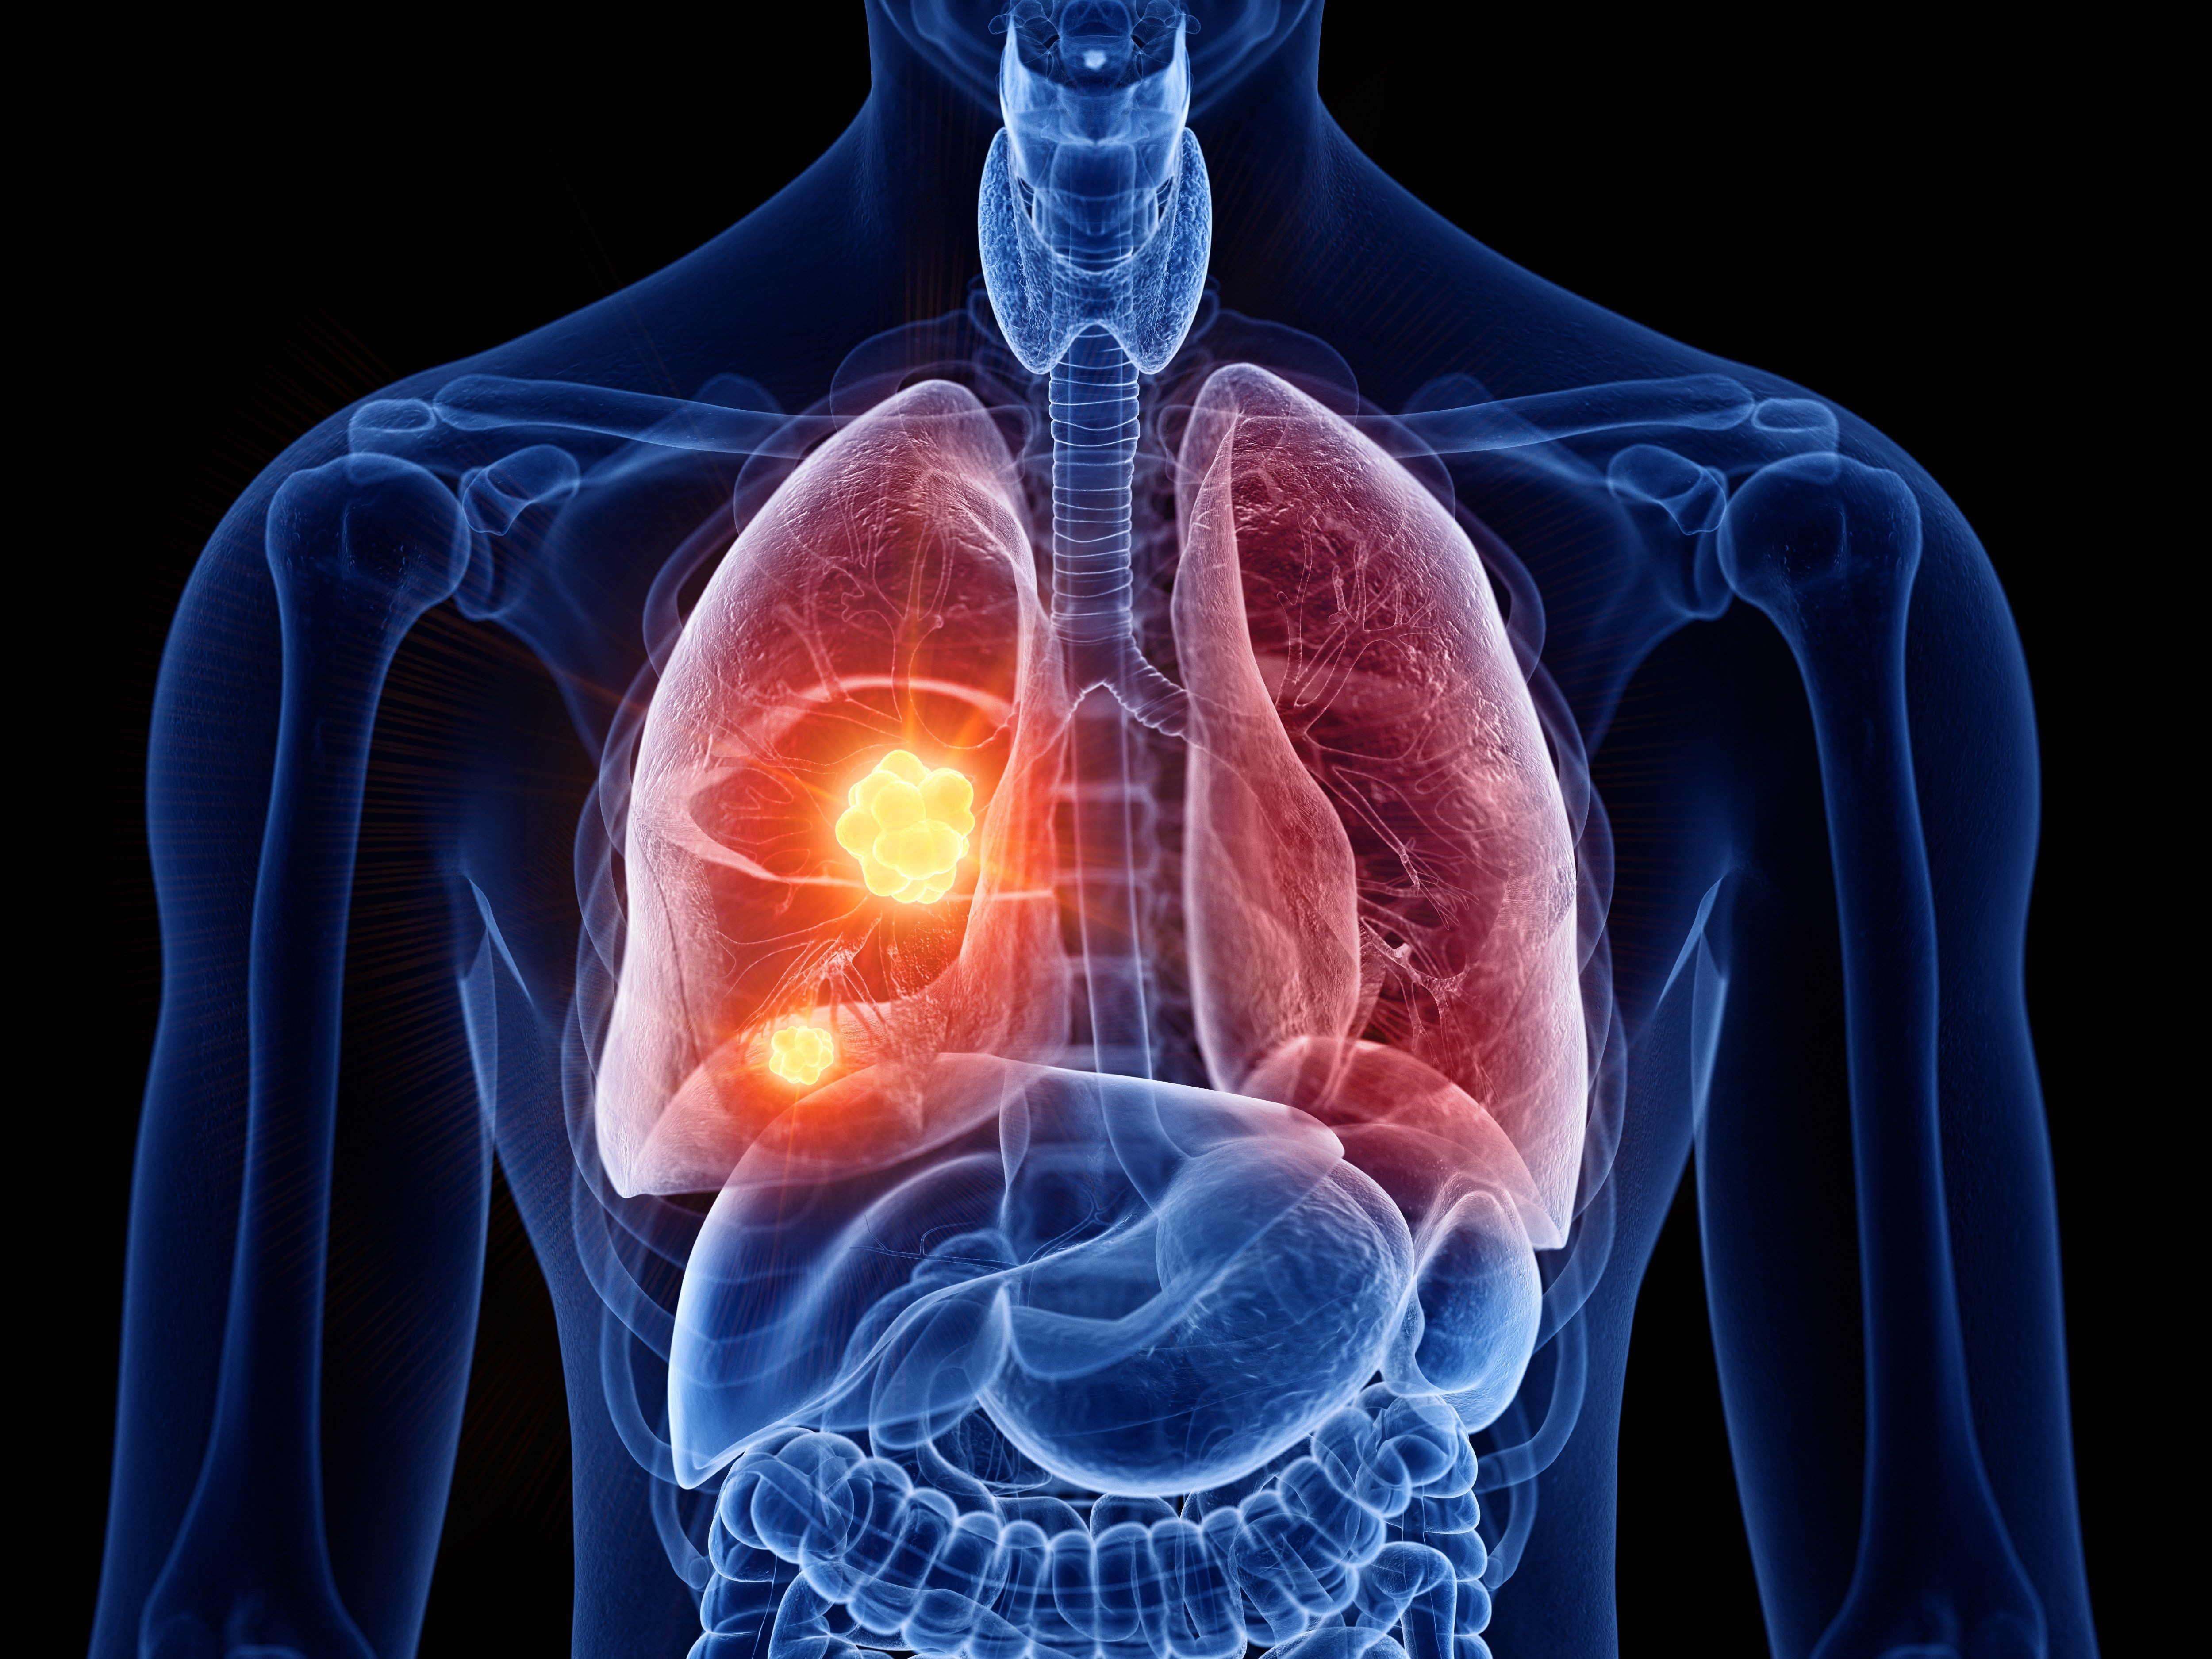

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv("dataset_med.csv")

print("\nFirst few rows of the dataset:")
print(df.head())

print("\n\nDataset Info:")
df.info()


First few rows of the dataset:
   id   age  gender      country diagnosis_date cancer_stage family_history  \
0   1  64.0    Male       Sweden     2016-04-05      Stage I            Yes   
1   2  50.0  Female  Netherlands     2023-04-20    Stage III            Yes   
2   3  65.0  Female      Hungary     2023-04-05    Stage III            Yes   
3   4  51.0  Female      Belgium     2016-02-05      Stage I             No   
4   5  37.0    Male   Luxembourg     2023-11-29      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4                199             0       0          1   
1  Passive Smoker  41.2                280             1       1          0   
2   Former Smoker  44.0                268             1       1          0   
3  Passive Smoker  43.0                241             1       1          0   
4  Passive Smoker  19.7                178             0       0          0   

   other_cancer tr

In [3]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                  id            age            bmi  cholesterol_level  \
count  890000.000000  890000.000000  890000.000000      890000.000000   
mean   445000.500000      55.007008      30.494172         233.633916   
std    256921.014127       9.994485       8.368539          43.432278   
min         1.000000       4.000000      16.000000         150.000000   
25%    222500.750000      48.000000      23.300000         196.000000   
50%    445000.500000      55.000000      30.500000         242.000000   
75%    667500.250000      62.000000      37.700000         271.000000   
max    890000.000000     104.000000      45.000000         300.000000   

        hypertension         asthma      cirrhosis   other_cancer  \
count  890000.000000  890000.000000  890000.000000  890000.000000   
mean        0.750024       0.469740       0.225956       0.088157   
std         0.432999       0.499084       0.418211       0.283524   
min         0.000000       0.000000       0.0

In [4]:
# Fill numeric columns with median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check for remaining missing values
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
id                    0
age                   0
gender                0
country               0
diagnosis_date        0
cancer_stage          0
family_history        0
smoking_status        0
bmi                   0
cholesterol_level     0
hypertension          0
asthma                0
cirrhosis             0
other_cancer          0
treatment_type        0
end_treatment_date    0
survived              0
dtype: int64


In [5]:
# Converting categorical columns to numerical
categorical_cols = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 
                    'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'survived']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Convering date columns to datetime format
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])
df['treatment_duration_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days
df.drop(['id', 'diagnosis_date', 'end_treatment_date'], axis=1, inplace=True)

print("\nDataset After Feature Engineering:")
print(df.head())



Dataset After Feature Engineering:
    age  gender  country  cancer_stage  family_history  smoking_status   bmi  \
0  64.0       1       26             0               1               3  29.4   
1  50.0       0       19             2               1               3  41.2   
2  65.0       0       12             2               1               1  44.0   
3  51.0       0        1             0               0               3  43.0   
4  37.0       1       17             0               0               3  19.7   

   cholesterol_level  hypertension  asthma  cirrhosis  other_cancer  \
0                199             0       0          1             0   
1                280             1       1          0             0   
2                268             1       1          0             0   
3                241             1       1          0             0   
4                178             0       0          0             0   

   treatment_type  survived  treatment_duration_days  
0

In [6]:
# Scale numeric features
scaler = StandardScaler()
numeric_cols = ['age', 'bmi', 'cholesterol_level', 'treatment_duration_days']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\nScaled Numeric Features:")
print(df[numeric_cols].head())



Scaled Numeric Features:
        age       bmi  cholesterol_level  treatment_duration_days
0  0.899796 -0.130748          -0.797424                 0.465906
1 -0.500977  1.279296           1.067550                -0.244658
2  0.999851  1.613882           0.791257                -0.632238
3 -0.400922  1.494387           0.169599                -0.108287
4 -1.801696 -1.289852          -1.280936                -0.373851


In [7]:
# Seperating features and target variable
X = df.drop("survived", axis=1)
y = df["survived"]

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nShape of Training and Testing Data:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Shape of Training and Testing Data:
X_train shape: (712000, 14)
X_test shape: (178000, 14)


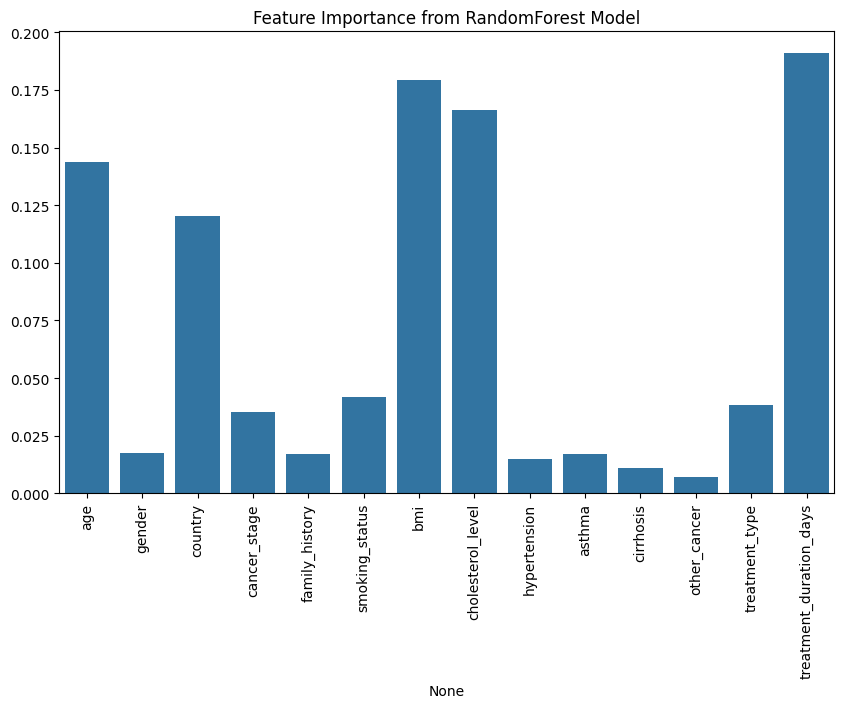

In [9]:
# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
features = X.columns

#Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=feature_importances)
plt.title("Feature Importance from RandomForest Model")
plt.xticks(rotation=90)
plt.show()


In [10]:
# Predictions
y_pred = model.predict(X_test)

In [11]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of the Model:", accuracy)


Accuracy of the Model: 0.7787303370786517


In [12]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.21      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.49      0.50      0.44    178000
weighted avg       0.65      0.78      0.68    178000



In [13]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("\nROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.5007144779482658
